Combined dataset shape: (1720991, 96)
Accuracy: 0.9999

Classification Report:
               precision    recall  f1-score   support

      Attack       1.00      1.00      1.00    154276
      Benign       1.00      1.00      1.00    362022

    accuracy                           1.00    516298
   macro avg       1.00      1.00      1.00    516298
weighted avg       1.00      1.00      1.00    516298



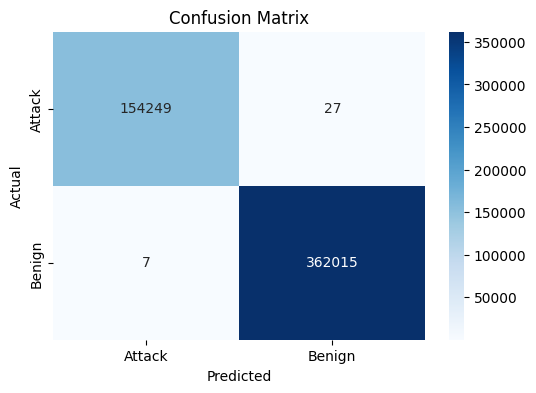

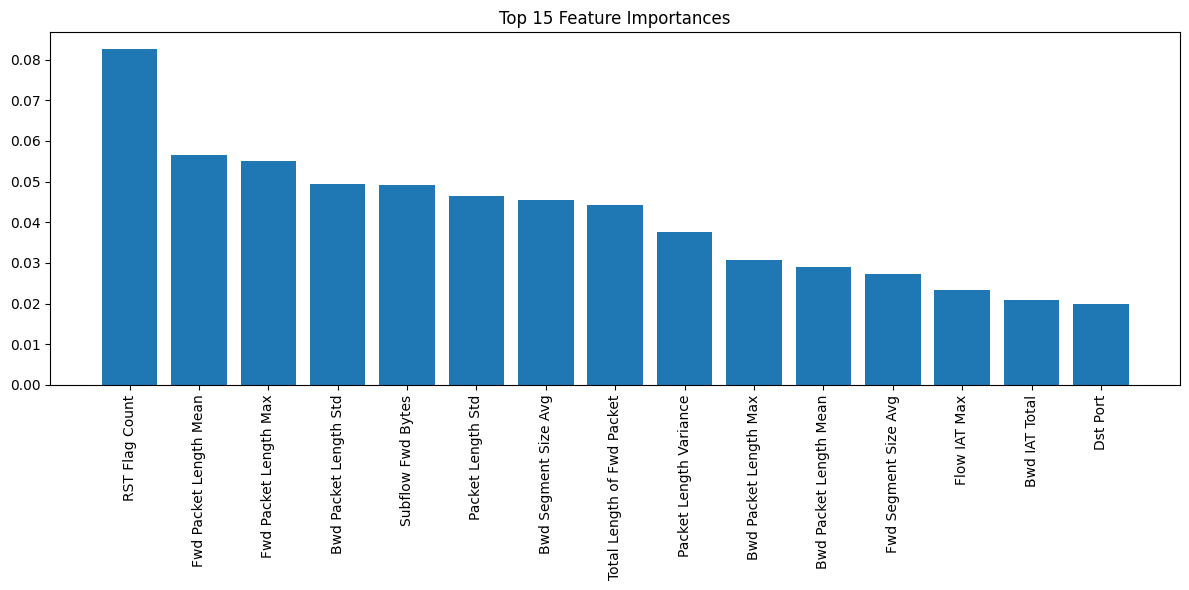

In [1]:
# CICIDS2017 Binary Classification — Combine all cleaned CSVs

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

# List of cleaned CSV files
cleaned_files = [
    'tuesday_plus_cleaned.csv',
    'wednesday_plus_cleaned.csv',
    'thursday_plus_cleaned.csv',
    'friday_plus_cleaned.csv'
]

# Load and combine all data
df_list = []
for file in cleaned_files:
    temp_df = pd.read_csv(file)
    df_list.append(temp_df)

df = pd.concat(df_list, ignore_index=True)

print(f"Combined dataset shape: {df.shape}")

# Drop non-feature columns that contain strings or identifiers
non_feature_cols = [
    'Flow ID',
    'Local', 'Local_1', 'Local_2', 'Local_3', 'Local_4', 'Local_5',
    'Local_6', 'Local_7', 'Local_8', 'Local_9', 'Local_10', 'Local_11',
    'Local_12', 'Local_13', 'Local_14'
]

df.drop(columns=non_feature_cols, inplace=True, errors='ignore')

# Map labels to binary: 'Benign' vs 'Attack'
df['Label'] = df['Label'].apply(lambda x: 'Benign' if x == 'Benign' else 'Attack')

# Separate features and target
X = df.drop('Label', axis=1)
y = df['Label']

# Encode categorical features (Protocol) if any
if 'Protocol' in X.columns and X['Protocol'].dtype == object:
    X = pd.get_dummies(X, columns=['Protocol'])

# Confirm all features are numeric
assert all([np.issubdtype(dtype, np.number) for dtype in X.dtypes]), "All features must be numeric!"

# Encode target labels
le = LabelEncoder()
y_enc = le.fit_transform(y)  # Benign=0, Attack=1

# Train-test split (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y_enc, test_size=0.3, random_state=42, stratify=y_enc
)

# Initialize and train Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predict on test data
y_pred = rf.predict(X_test)

# Evaluation metrics
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}\n")
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=le.classes_))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Plot feature importance (top 15)
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12,6))
plt.title("Top 15 Feature Importances")
plt.bar(range(15), importances[indices][:15], align="center")
plt.xticks(range(15), X.columns[indices][:15], rotation=90)
plt.tight_layout()
plt.show()


In [4]:
# After combining all cleaned data (df), shuffle before split
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Check for duplicated rows in the entire dataset
print(f"Total duplicates in full dataset: {df.duplicated().sum()}")

# Optional: Drop duplicates before train/test split
df = df.drop_duplicates()

# Now split the data day-wise for leakage test:
# Let's assume you still have day info? If not, check duplicate rows between train/test below.


Total duplicates in full dataset: 5260


In [25]:
import pandas as pd

# List of cleaned CSV files
cleaned_files = [
    'tuesday_plus_cleaned.csv',
    'wednesday_plus_cleaned.csv',
    'thursday_plus_cleaned.csv',
    'friday_plus_cleaned.csv'
]

# Load and combine all CSV files into one DataFrame
df_list = [pd.read_csv(file) for file in cleaned_files]
df = pd.concat(df_list, ignore_index=True)

print(f"Combined dataset shape: {df.shape}")

# Drop unwanted columns if needed, for example identifiers
non_feature_cols = [
    'Flow ID',
    'Local', 'Local_1', 'Local_2', 'Local_3', 'Local_4', 'Local_5',
    'Local_6', 'Local_7', 'Local_8', 'Local_9', 'Local_10', 'Local_11',
    'Local_12', 'Local_13', 'Local_14'
]

df.drop(columns=non_feature_cols, inplace=True, errors='ignore')

# Make sure your 'Label' column is properly formatted
# For example, binary mapping (adjust if multiclass):
df['Label'] = df['Label'].apply(lambda x: 'Benign' if x == 'Benign' else 'Attack')

# Now you can run your previous code to separate X and y, encode, split, and do SMOTE


Combined dataset shape: (1720991, 96)


Original training set shape: Counter({np.int64(1): 844716, np.int64(0): 359977})
Resampled training set shape: Counter({np.int64(1): 844716, np.int64(0): 844716})
Accuracy: 0.9999
              precision    recall  f1-score   support

      Attack       1.00      1.00      1.00    154276
      Benign       1.00      1.00      1.00    362022

    accuracy                           1.00    516298
   macro avg       1.00      1.00      1.00    516298
weighted avg       1.00      1.00      1.00    516298



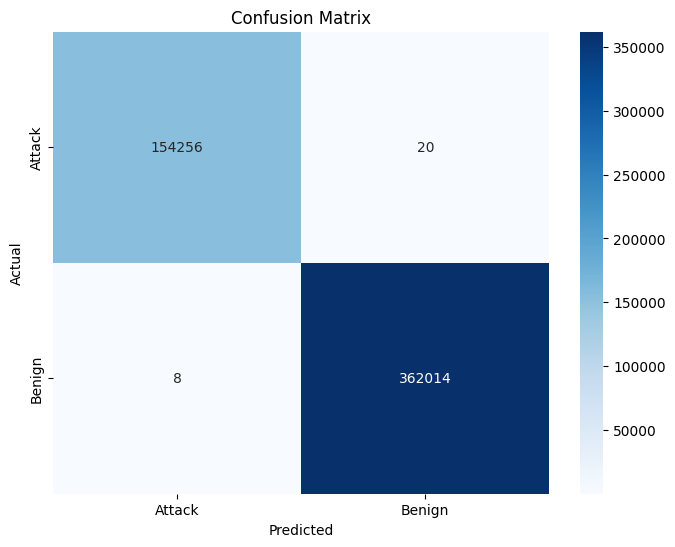

In [35]:
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE

# Assuming df is your loaded and cleaned dataset
# Map labels if needed, here assuming multiclass labels are intact

# Separate features and target
X = df.drop('Label', axis=1)
y = df['Label']

# Encode target labels if they are strings
le = LabelEncoder()
y_enc = le.fit_transform(y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_enc, test_size=0.3, random_state=42, stratify=y_enc
)

print("Original training set shape:", Counter(y_train))

# Apply SMOTE to training data only
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print("Resampled training set shape:", Counter(y_train_res))

# Train classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_res, y_train_res)

# Predict on test set
y_pred = rf.predict(X_test)

# Evaluate
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [36]:
train_rows = X_train.copy()
train_rows['Label'] = y_train

test_rows = X_test.copy()
test_rows['Label'] = y_test

# Create combined string key of all features + label
train_rows['combined'] = train_rows.astype(str).agg('_'.join, axis=1)
test_rows['combined'] = test_rows.astype(str).agg('_'.join, axis=1)

# Find duplicates in test that are also in train
duplicates = test_rows['combined'].isin(train_rows['combined'])

print(f"Duplicates in test also in train: {duplicates.sum()}")

# Remove duplicates from test
test_rows_clean = test_rows[~duplicates].drop(columns=['combined'])

X_test_clean = test_rows_clean.drop('Label', axis=1)
y_test_clean = test_rows_clean['Label']

print(f"Cleaned test set shape: {X_test_clean.shape}")

# Predict on cleaned test
y_pred_clean = rf.predict(X_test_clean)

from sklearn.metrics import accuracy_score, classification_report
print(f"Accuracy on cleaned test set: {accuracy_score(y_test_clean, y_pred_clean):.4f}")
print(classification_report(y_test_clean, y_pred_clean, target_names=le.classes_))


Duplicates in test also in train: 2049
Cleaned test set shape: (514249, 79)
Accuracy on cleaned test set: 0.9999
              precision    recall  f1-score   support

      Attack       1.00      1.00      1.00    154275
      Benign       1.00      1.00      1.00    359974

    accuracy                           1.00    514249
   macro avg       1.00      1.00      1.00    514249
weighted avg       1.00      1.00      1.00    514249



In [38]:
print(df.columns.tolist())



['Src Port', 'Dst Port', 'Protocol', 'Flow Duration', 'Total Fwd Packet', 'Total Bwd packets', 'Total Length of Fwd Packet', 'Total Length of Bwd Packet', 'Fwd Packet Length Max', 'Fwd Packet Length Min', 'Fwd Packet Length Mean', 'Fwd Packet Length Std', 'Bwd Packet Length Max', 'Bwd Packet Length Min', 'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'Fwd RST Flags', 'Bwd RST Flags', 'Fwd Header Length', 'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s', 'Packet Length Min', 'Packet Length Max', 'Packet Length Mean', 'Packet Length Std', 'Packet Length Variance', 'FIN Flag Count', 'SYN Flag Count', 'RST Flag Count', 'PSH Flag Count', 'ACK Flag Count', 'URG Flag

In [41]:
# Assuming 'Label' is your target column
X = df.drop(columns=['Label', 'Attempted Category'])  # Drop both labels if 'Attempted Category' is not needed
y = df['Label']  # or use y = df['Attempted Category'] if that is your actual target


In [42]:
print(df.columns.tolist())

['Src Port', 'Dst Port', 'Protocol', 'Flow Duration', 'Total Fwd Packet', 'Total Bwd packets', 'Total Length of Fwd Packet', 'Total Length of Bwd Packet', 'Fwd Packet Length Max', 'Fwd Packet Length Min', 'Fwd Packet Length Mean', 'Fwd Packet Length Std', 'Bwd Packet Length Max', 'Bwd Packet Length Min', 'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'Fwd RST Flags', 'Bwd RST Flags', 'Fwd Header Length', 'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s', 'Packet Length Min', 'Packet Length Max', 'Packet Length Mean', 'Packet Length Std', 'Packet Length Variance', 'FIN Flag Count', 'SYN Flag Count', 'RST Flag Count', 'PSH Flag Count', 'ACK Flag Count', 'URG Flag

Original training set shape: Counter({np.int64(1): 844716, np.int64(0): 359977})
Resampled training set shape: Counter({np.int64(1): 844716, np.int64(0): 844716})
Accuracy: 0.9999
              precision    recall  f1-score   support

      Attack       1.00      1.00      1.00    154276
      Benign       1.00      1.00      1.00    362022

    accuracy                           1.00    516298
   macro avg       1.00      1.00      1.00    516298
weighted avg       1.00      1.00      1.00    516298



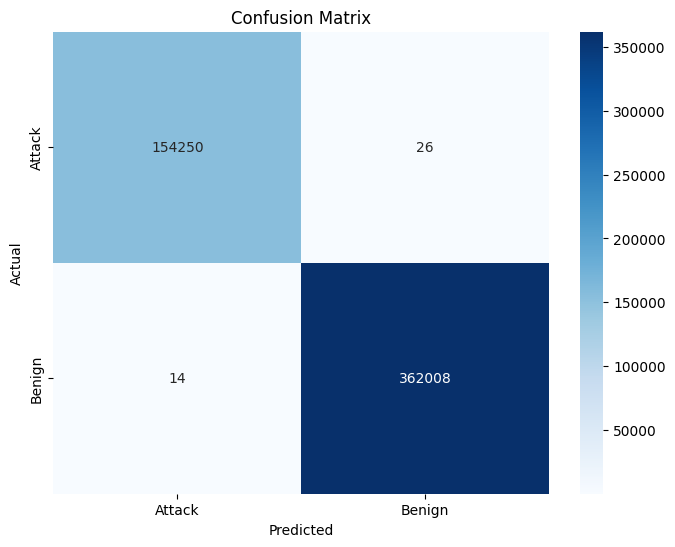

In [43]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Encode target labels if they are strings
le = LabelEncoder()
y_enc = le.fit_transform(y)

# Split data into train and test sets (stratify to preserve label proportions)
X_train, X_test, y_train, y_test = train_test_split(
    X, y_enc, test_size=0.3, random_state=42, stratify=y_enc
)

print("Original training set shape:", Counter(y_train))

# Apply SMOTE only on training data to balance classes
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print("Resampled training set shape:", Counter(y_train_res))

# Train a Random Forest classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_res, y_train_res)

# Predict on the original test set
y_pred = rf.predict(X_test)

# Evaluate the model
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [44]:
from sklearn.metrics import accuracy_score

# Predict on training data
y_train_pred = rf.predict(X_train_res)
train_accuracy = accuracy_score(y_train_res, y_train_pred)
print(f"Training accuracy: {train_accuracy:.4f}")

# You already have test accuracy:
print(f"Test accuracy: {accuracy_score(y_test, y_pred):.4f}")


Training accuracy: 1.0000
Test accuracy: 0.9999


In [45]:
from sklearn.model_selection import cross_val_score #to test the ability of a machine learning model to predict new data

cv_scores = cross_val_score(rf, X_train_res, y_train_res, cv=5, scoring='accuracy')
print("Cross-validation scores:", cv_scores)
print("Mean CV accuracy:", cv_scores.mean())


Cross-validation scores: [0.99989346 0.99988458 0.99989937 0.99990825 0.99992305]
Mean CV accuracy: 0.9999017421390455


In [27]:
# Check for duplicates between train and test
train_rows = X_train.copy()
train_rows['Label'] = y_train

test_rows = X_test.copy()
test_rows['Label'] = y_test

# Merge on all columns to find duplicates
merged = pd.merge(train_rows, test_rows, how='inner')

print(f"Number of duplicate rows between train and test: {merged.shape[0]}")


Number of duplicate rows between train and test: 5600


In [46]:
print(rf)
print(len(rf.estimators_))  # should be > 0


RandomForestClassifier(random_state=42)
100


Original training set shape: Counter({np.int64(1): 965390, np.int64(0): 411402})
Resampled training set shape: Counter({np.int64(1): 965390, np.int64(0): 965390})
Initial Test Accuracy: 0.9999
              precision    recall  f1-score   support

      Attack       1.00      1.00      1.00    102851
      Benign       1.00      1.00      1.00    241348

    accuracy                           1.00    344199
   macro avg       1.00      1.00      1.00    344199
weighted avg       1.00      1.00      1.00    344199


Cleaned test set shape: (342423, 78)
Duplicates removed: 1776

Accuracy on cleaned test set: 0.9999
              precision    recall  f1-score   support

      Attack       1.00      1.00      1.00    102517
      Benign       1.00      1.00      1.00    239906

    accuracy                           1.00    342423
   macro avg       1.00      1.00      1.00    342423
weighted avg       1.00      1.00      1.00    342423



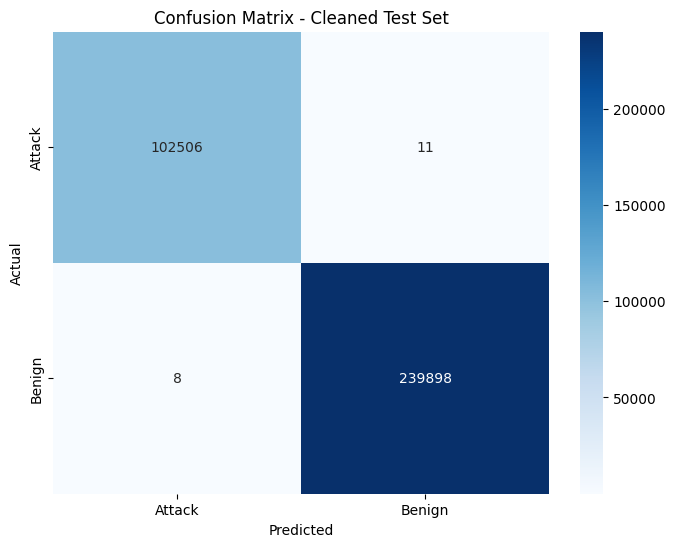

/var/folders/y5/6j_khfx9703159vgp4qxsqzw0000gn/T/ipykernel_16907/328957259.py:90: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances[indices[:20]], y=features[indices[:20]], palette="viridis")


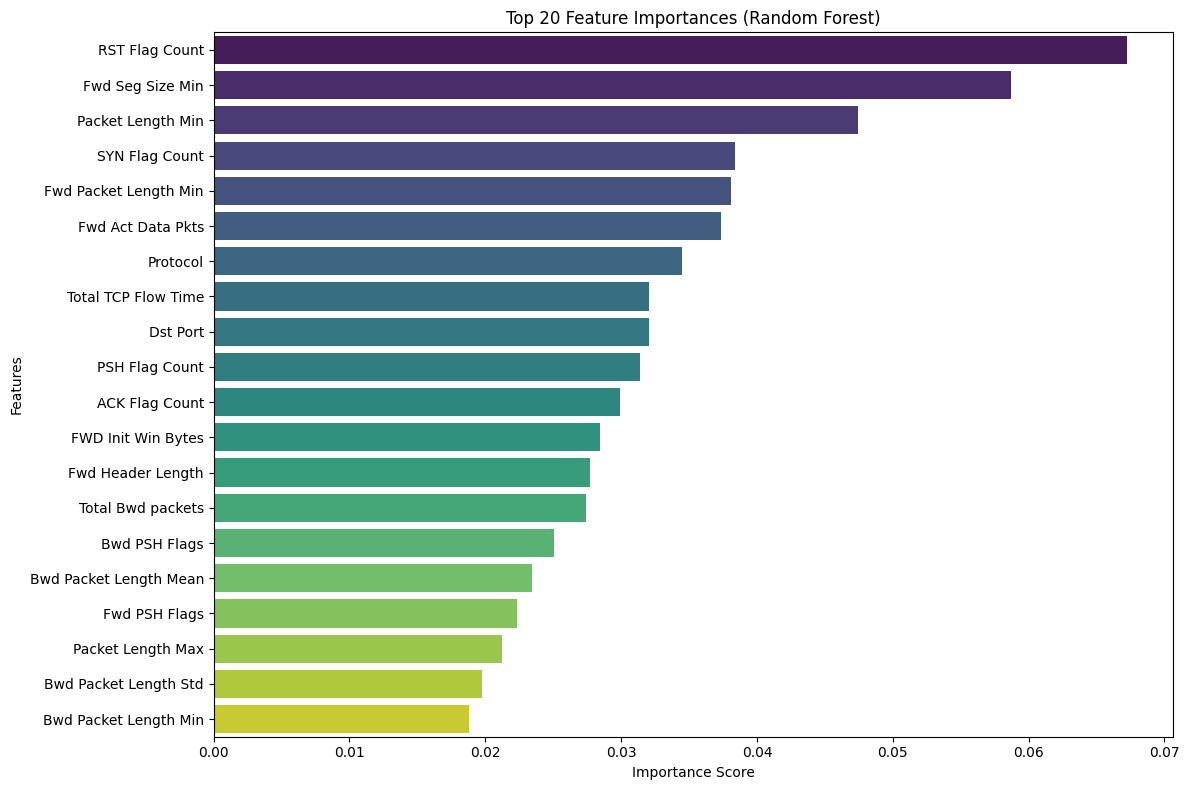

In [47]:
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Load your combined and preprocessed dataframe
# df = pd.read_csv('your_cleaned_data.csv')  # Replace with actual loading step

# Assuming your data is already in df
X = df.drop(columns=['Label', 'Attempted Category'])  # Drop both if only using one
y = df['Label']

# Encode label
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

print("Original training set shape:", Counter(y_train))

# Apply SMOTE
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("Resampled training set shape:", Counter(y_train_resampled))

# Train Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_resampled, y_train_resampled)

# Predictions on full test set
y_pred = rf.predict(X_test)

print(f"Initial Test Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# ---------------------------
# 🔍 Clean test set by removing training duplicates
train_rows = pd.DataFrame(X_train_resampled, columns=X.columns)
train_rows['Label'] = y_train_resampled

test_rows = pd.DataFrame(X_test, columns=X.columns)
test_rows['Label'] = y_test

train_rows['combined'] = train_rows.apply(lambda row: '_'.join(row.astype(str)), axis=1)
test_rows['combined'] = test_rows.apply(lambda row: '_'.join(row.astype(str)), axis=1)

test_rows_clean = test_rows[~test_rows['combined'].isin(train_rows['combined'])].drop(columns=['combined'])

X_test_clean = test_rows_clean.drop('Label', axis=1)
y_test_clean = test_rows_clean['Label']

print(f"\nCleaned test set shape: {X_test_clean.shape}")
print(f"Duplicates removed: {len(test_rows) - len(test_rows_clean)}")

# ✅ Predict on cleaned test set
y_pred_clean = rf.predict(X_test_clean)

print(f"\nAccuracy on cleaned test set: {accuracy_score(y_test_clean, y_pred_clean):.4f}")
print(classification_report(y_test_clean, y_pred_clean, target_names=le.classes_))

# ---------------------------
# 📊 Confusion Matrix
cm_clean = confusion_matrix(y_test_clean, y_pred_clean)

plt.figure(figsize=(8,6))
sns.heatmap(cm_clean, annot=True, fmt='d',
            xticklabels=le.classes_, yticklabels=le.classes_, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Cleaned Test Set')
plt.show()

# ---------------------------
# 📈 Feature Importance
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
features = X.columns

plt.figure(figsize=(12, 8))
sns.barplot(x=importances[indices[:20]], y=features[indices[:20]], palette="viridis")
plt.title("Top 20 Feature Importances (Random Forest)")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.tight_layout()
plt.show()




In [30]:
# Drop columns that can leak info
leak_cols = ['Flow ID', 'Timestamp', 'flow_id', 'Label']  # Add as needed
X = df.drop(columns=leak_cols, errors='ignore')


In [31]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=42)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(rf, X, y_enc, cv=skf, scoring='accuracy')

print(f"Cross-validation accuracy scores: {scores}")
print(f"Mean CV accuracy: {scores.mean():.4f}")


Cross-validation accuracy scores: [0.99995061 0.9999477  0.99993027 0.99993608 0.99994189]
Mean CV accuracy: 0.9999


In [48]:
import joblib

# Save the model to a file
joblib.dump(rf, 'random_forest_model.joblib')

# To load it later:
# rf_loaded = joblib.load('random_forest_model.joblib')


['random_forest_model.joblib']